In [2]:
# install deepxde

%pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 5.5 MB/s eta 0:00:00


In [3]:
# import packages

import deepxde as dde
import numpy as np

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



In [4]:
# set up the ode system

def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)

    return [dy1_x - y2, dy2_x + y1]


def boundary(_, on_initial):
    return on_initial


def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))

In [5]:
# define ivp

geom = dde.geometry.TimeDomain(0, 10)
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

In [6]:
# set up the model

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [7]:
# train the model

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.064940 s



/usr/local/lib/python3.9/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.808048 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.45e-02, 2.15e-02, 0.00e+00, 1.00e+00]    [1.50e-02, 2.18e-02, 0.00e+00, 1.00e+00]    [1.04e+00]    
1000      [8.26e-03, 6.86e-03, 1.37e-08, 2.89e-04]    [9.29e-03, 6.79e-03, 1.37e-08, 2.89e-04]    [7.67e-01]    
2000      [3.70e-03, 3.46e-03, 2.90e-07, 6.54e-05]    [3.80e-03, 3.59e-03, 2.90e-07, 6.54e-05]    [4.98e-01]    
3000      [6.26e-04, 7.60e-04, 2.93e-06, 5.63e-06]    [6.87e-04, 5.92e-04, 2.93e-06, 5.63e-06]    [1.51e-01]    
4000      [7.05e-05, 1.45e-04, 2.17e-07, 4.29e-07]    [7.01e-05, 9.77e-05, 2.17e-07, 4.29e-07]    [4.90e-02]    
5000      [1.71e-05, 5.03e-05, 4.53e-08, 6.80e-08]    [1.52e-05, 3.61e-05, 4.53e-08, 6.80e-08]    [2.00e-02]    
6000      [6.89e-06, 2.45e-05, 1.12e-08, 1.70e-08]    [6.37e-06, 2.08e-05, 1.12e-08, 1.70e-08]    [1.03e-02]    
7000      [4.92e-06, 1.7

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


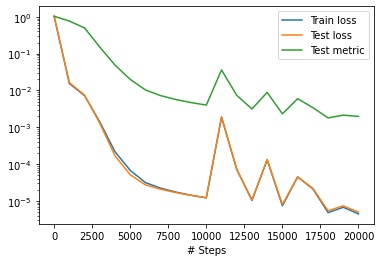

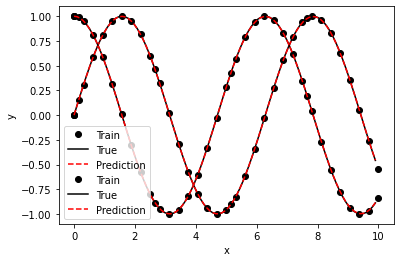

In [8]:
# plot the loss

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [28]:
# generate data from the true solution in [0, 20]

x = np.linspace(0, 15, 1000)
y_true = func(x)
y_true_sin = y_true[:1000]
y_true_cos = y_true[1000:]

# turn x into a proper input for the model
x = np.reshape(x, (1000, 1))

# predict the solution at x
y_pred = model.predict(x)

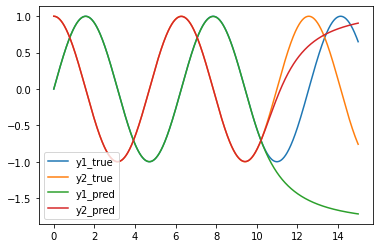

In [32]:
# plot the solution

import matplotlib.pyplot as plt

plt.plot(x, y_true_sin, label="y1_true")
plt.plot(x, y_true_cos, label="y2_true")
plt.plot(x, y_pred[:, 0], label="y1_pred")
plt.plot(x, y_pred[:, 1], label="y2_pred")
plt.legend(loc = "lower left")
plt.show()

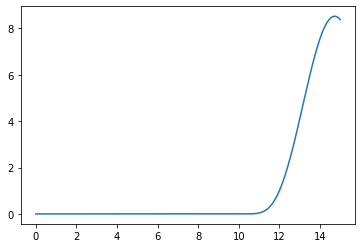

In [30]:
# add the L2 error between y_true_sin and y_pred[:, 0] and y_true_cos and y_pred[:, 1]
# and plot the cumulative error

plt.plot(x, np.square(y_true_sin - y_pred[:, 0]) + np.square(y_true_cos - y_pred[:, 1]))
plt.show()